## Project: Plant Seedlings

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained model based on the VGG16 model.

Used Dataset from: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset

The model is trained on food images to distinguish plant seeds divided in 12 classes: Black Grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen, Loose Silky Bent, Maize, Scentless Mayweed, Shepherd Purse, Small flowered Cranesbill, and Sugar Beet.

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [1]:
#!pip install tensorflow==2.15.0

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#! cp /content/drive/MyDrive/Dog_Breed_Dataset.zip .

In [4]:
#!unzip Dog_Breed_Dataset.zip

In [5]:
!python3 --version

Python 3.10.12


Check what GPU I've been assigned.

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug  5 15:46:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   70C    P0              25W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Memory info

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/content/Dog_Breed_Dataset"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Shuffle images from directory into train, valid, and test sets

In [12]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [13]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True,
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)),
                                               shuffle=True,random_state=rs)

                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [14]:
# Print the count of items from each class

count = 0
for folder in os.listdir(train_dir):
    folder_pics = len(os.listdir(os.path.join(train_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The kuvasz class has 104 pictures.
The miniature_pinscher class has 128 pictures.
The Old_English_sheepdog class has 118 pictures.
The pug class has 139 pictures.
The Irish_setter class has 108 pictures.
The English_foxhound class has 109 pictures.
The miniature_poodle class has 108 pictures.
The malamute class has 124 pictures.
The EntleBucher class has 141 pictures.
The Labrador_retriever class has 119 pictures.
The Yorkshire_terrier class has 114 pictures.
The English_springer class has 111 pictures.
The Scotch_terrier class has 110 pictures.
The Lakeland_terrier class has 137 pictures.
The whippet class has 130 pictures.
The giant_schnauzer class has 109 pictures.
The schipperke class has 107 pictures.
The Samoyed class has 152 pictures.
The Airedale class has 141 pictures.
The Brittany_spaniel class has 106 pictures.
The Siberian_husky class has 134 pictures.
The miniature_schnauzer class has 107 pictures.
The West_Highland_white_terrier class has 118 pictures.
The curly-coated_re

## Let us have a look at the classes we are going to classify

In [15]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(train_dir):
    pics = random.choice(os.listdir(os.path.join(train_dir, folder)))
    path_pic = os.path.join(train_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

#print(image_examples_dict)

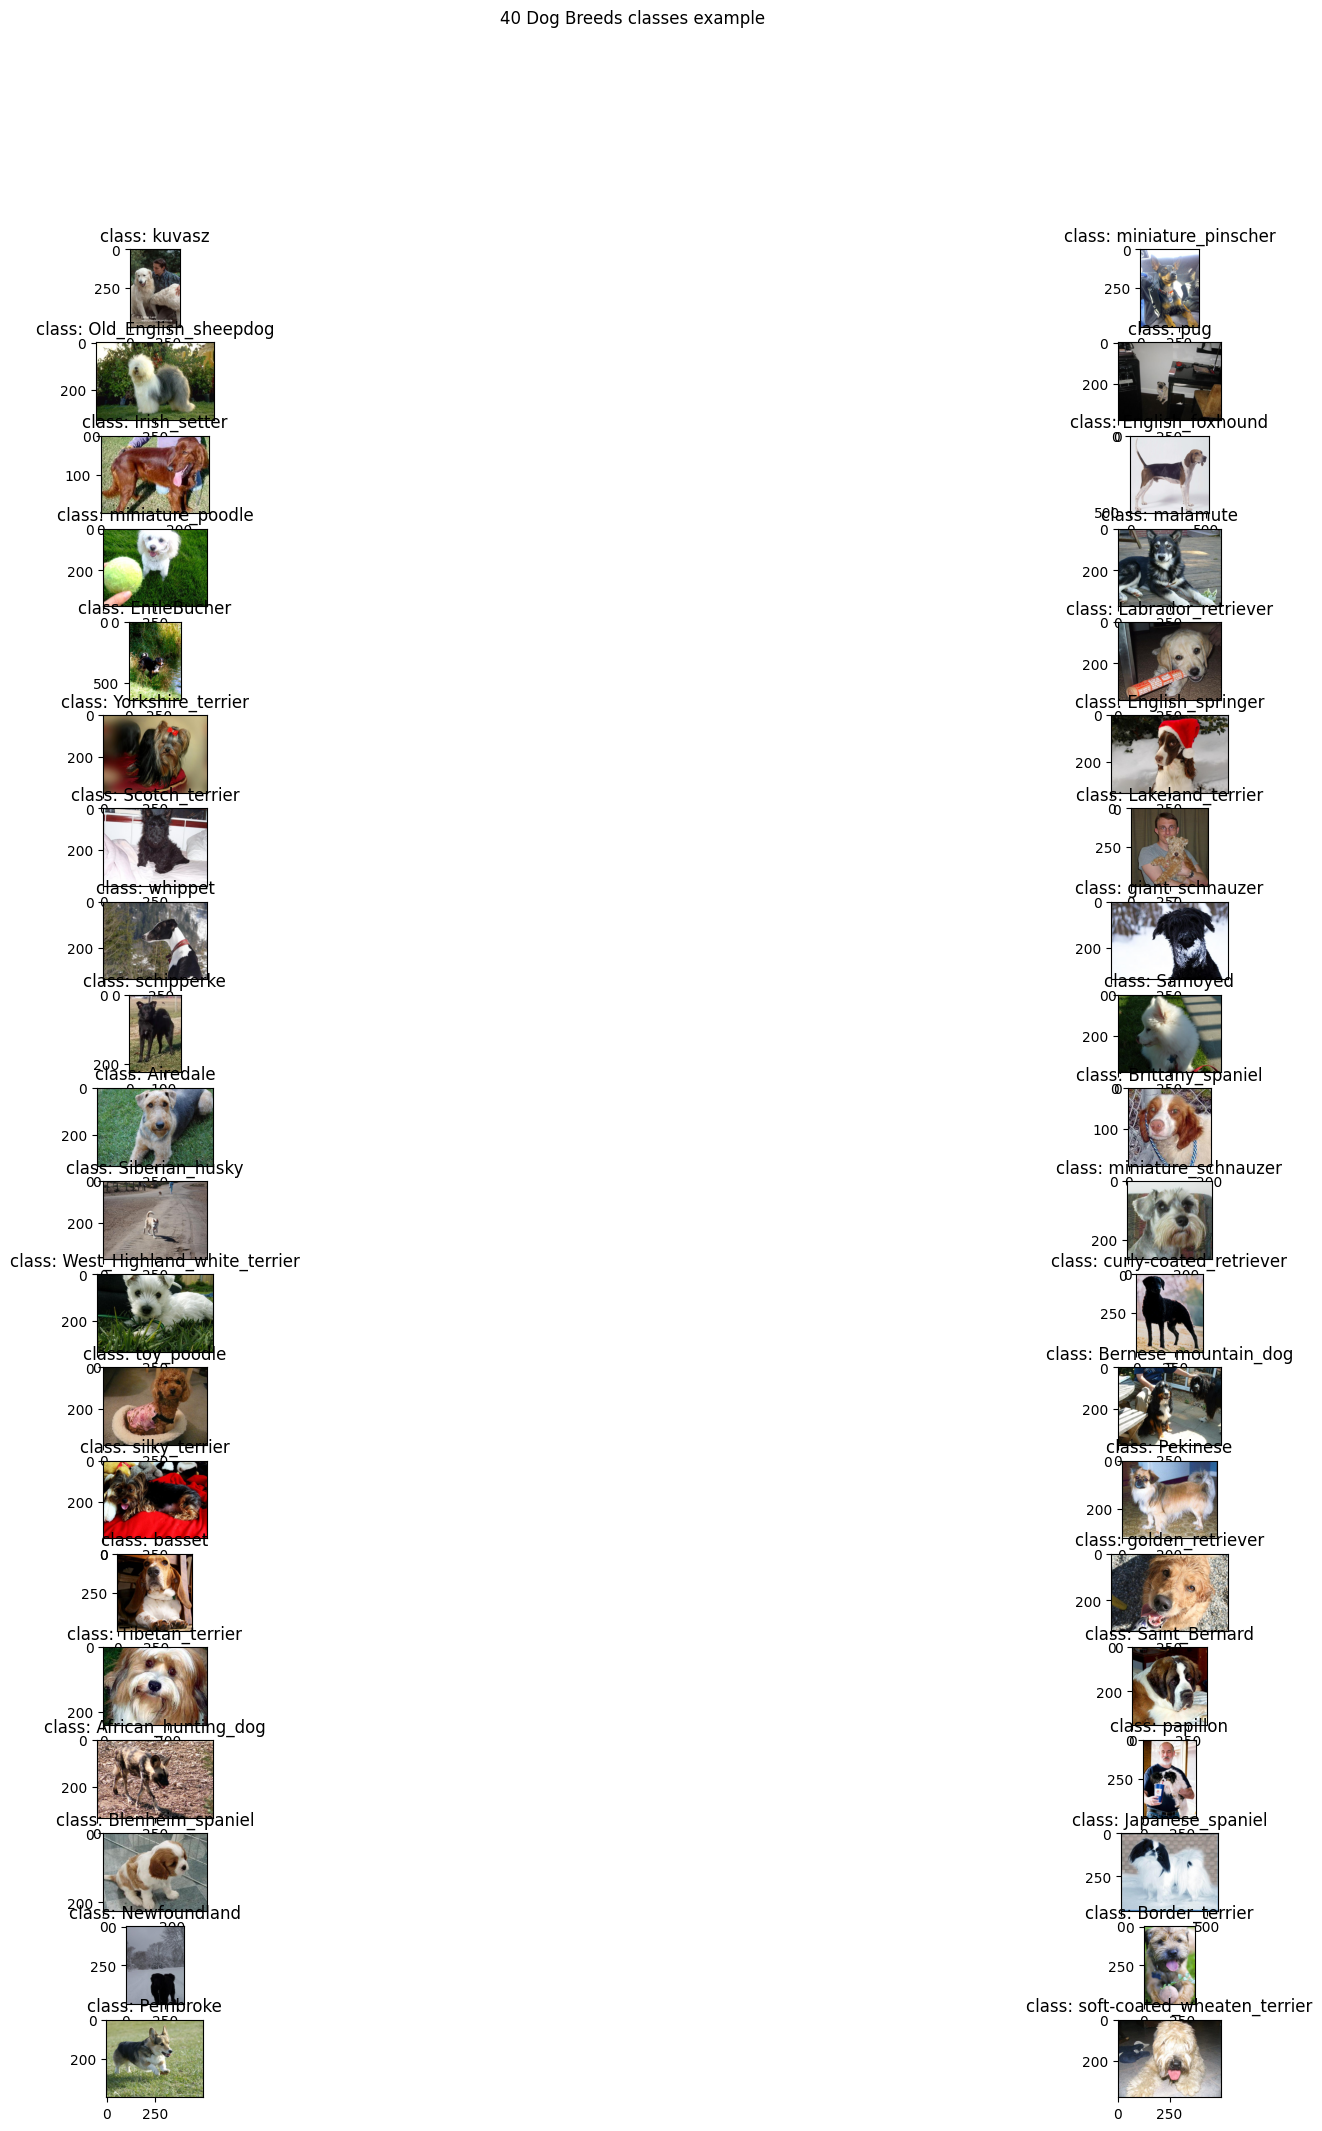

In [16]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(24, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('40 Dog Breeds classes example')
plt.show()

## Model definition


In [17]:
# here I define some important parameter that are going to be used in both models

#num_classes =

image_resize = 224

batch_size_training = 56
batch_size_validation = 56

#num_epochs = 8 * 4

In [18]:
# instantiate the image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Now we can generate train and validation set with ImageDataGenerator

In [19]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

Found 14338 images belonging to 120 classes.


In [20]:
validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
)

Found 3097 images belonging to 120 classes.


In [21]:
num_classes = train_generator.num_classes
print("number of automatically found classes: ",num_classes)

number of automatically found classes:  120


In [22]:
class_names = {y: x for x, y in validation_generator.class_indices.items()}
class_names

{0: 'Afghan_hound',
 1: 'African_hunting_dog',
 2: 'Airedale',
 3: 'American_Staffordshire_terrier',
 4: 'Appenzeller',
 5: 'Australian_terrier',
 6: 'Bedlington_terrier',
 7: 'Bernese_mountain_dog',
 8: 'Blenheim_spaniel',
 9: 'Border_collie',
 10: 'Border_terrier',
 11: 'Boston_bull',
 12: 'Bouvier_des_Flandres',
 13: 'Brabancon_griffon',
 14: 'Brittany_spaniel',
 15: 'Cardigan',
 16: 'Chesapeake_Bay_retriever',
 17: 'Chihuahua',
 18: 'Dandie_Dinmont',
 19: 'Doberman',
 20: 'English_foxhound',
 21: 'English_setter',
 22: 'English_springer',
 23: 'EntleBucher',
 24: 'Eskimo_dog',
 25: 'French_bulldog',
 26: 'German_shepherd',
 27: 'German_short-haired_pointer',
 28: 'Gordon_setter',
 29: 'Great_Dane',
 30: 'Great_Pyrenees',
 31: 'Greater_Swiss_Mountain_dog',
 32: 'Ibizan_hound',
 33: 'Irish_setter',
 34: 'Irish_terrier',
 35: 'Irish_water_spaniel',
 36: 'Irish_wolfhound',
 37: 'Italian_greyhound',
 38: 'Japanese_spaniel',
 39: 'Kerry_blue_terrier',
 40: 'Labrador_retriever',
 41: 'Lak

Here we define some optimization parameters that are going to be used with both models.

In [23]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

print(steps_per_epoch_training,steps_per_epoch_validation)

257 56


## Build the model

### we start with the tailored-made CNN model

In [24]:

def get_model_cnn():
    input = Input(shape=(image_resize,image_resize,3,)) # (None, 224, 224, 3)

    conv1  = Conv2D(64,(3,3),activation='relu',padding="same")(input)
    conv1  = Conv2D(64,(3,3),activation='relu',padding="same")(conv1)
    pool1  = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2  = Conv2D(128,(3,3),activation='relu')(pool1)
    conv2  = Conv2D(128,(3,3),activation='relu')(conv2)
    pool2  = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(256,(3,3),activation='relu')(pool2)
    conv3 = Conv2D(256,(3,3),activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(512,(3,3),activation='relu')(pool3)
    conv4 = Conv2D(512,(3,3),activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = Conv2D(1024,(3,3),activation='relu')(pool4)
    conv5 = Conv2D(1024,(3,3),activation='relu')(conv5)
    pool5 = MaxPooling2D(pool_size=(2,2))(conv5)

    flat = Flatten()(pool5)

    drop  = Dropout(0.2)(flat)
    fully = Dense(1024, activation='relu')(drop)
    drop  = Dropout(0.2)(fully)
    fully = Dense(1024, activation='relu')(drop)
    drop  = Dropout(0.2)(fully)
    fully = Dense(512, activation='relu')(drop)

    pred  = Dense(num_classes, activation='softmax')(fully)

    model = Model(inputs=input, outputs=pred)

    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [25]:
model_cnn = get_model_cnn()

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 128)     147584    
                                                             

In [26]:
model_cnn.layers

In [40]:
%%time

num_epochs = 8 * 3

start_datetime = datetime.now()

with tf.device('/gpu:0'):
  fit_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
  )

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/24
257/257 [==============================] - 89s 348ms/step - loss: 3.4648 - accuracy: 0.1792 - val_loss: 4.0643 - val_accuracy: 0.0956
Epoch 2/24
257/257 [==============================] - 90s 350ms/step - loss: 3.2939 - accuracy: 0.2118 - val_loss: 3.9918 - val_accuracy: 0.1120
Epoch 3/24
257/257 [==============================] - 89s 348ms/step - loss: 3.2306 - accuracy: 0.2246 - val_loss: 4.0454 - val_accuracy: 0.0972
Epoch 4/24
257/257 [==============================] - 90s 348ms/step - loss: 3.0767 - accuracy: 0.2486 - val_loss: 4.0770 - val_accuracy: 0.1169
Epoch 5/24
257/257 [==============================] - 90s 349ms/step - loss: 3.0401 - accuracy: 0.2643 - val_loss: 4.0037 - val_accuracy: 0.1091
Epoch 6/24
257/257 [==============================] - 90s 349ms/step - loss: 2.7636 - accuracy: 0.3146 - val_loss: 4.0273 - val_accuracy: 0.1256
Epoch 7/24
257/257 [==============================] - 90s 348ms/step - loss: 3.4147 - accuracy: 0.2235 - val_loss: 4.1405 - val_ac

KeyboardInterrupt: 

In [28]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
)

Found 3145 images belonging to 120 classes.


In [29]:
# Evaluate CNN on test_generator

test_generator.reset()
eval_cnn = model_cnn.evaluate(test_generator)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

3145/3145 [==============================] - 18s 5ms/step - loss: 3.9591 - accuracy: 0.0992
CNN Test loss:  3.9591257572174072
CNN Test Accuracy:  0.09920508414506912


In [30]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "."
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")

save_model(model_cnn, "classifier_cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model updated


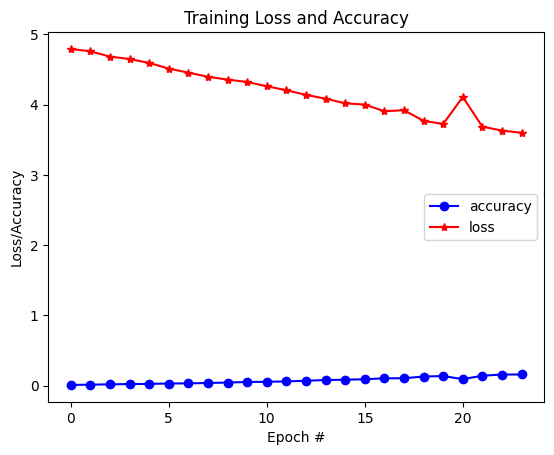

In [31]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# VGG16

In [41]:
del(model_vgg)

## Now that we trained and saved the CNN model, we train a pre-trained model based on the VGG16 model.

In [42]:
def get_model_vgg():

    base_model = VGG16(weights='imagenet', include_top=False) #imports the VGG16 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = keras.layers.GlobalAveragePooling2D()(x) # (None, 512)

    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(1024,activation='relu')(x) # (None, 1024)
    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(512,activation='relu')(x) # (None, 512)

    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [43]:
model_vgg = get_model_vgg()

model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [44]:
model_vgg.layers

In [45]:
%%time

num_epochs = 18

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/18
257/257 [==============================] - 56s 211ms/step - loss: 3.3446 - accuracy: 0.2648 - val_loss: 1.6996 - val_accuracy: 0.5237
Epoch 2/18
257/257 [==============================] - 54s 209ms/step - loss: 1.9028 - accuracy: 0.4770 - val_loss: 1.3655 - val_accuracy: 0.6174
Epoch 3/18
257/257 [==============================] - 54s 209ms/step - loss: 1.6227 - accuracy: 0.5358 - val_loss: 1.2937 - val_accuracy: 0.6267
Epoch 4/18
257/257 [==============================] - 54s 209ms/step - loss: 1.5121 - accuracy: 0.5601 - val_loss: 1.2650 - val_accuracy: 0.6325
Epoch 5/18
257/257 [==============================] - 54s 209ms/step - loss: 1.4311 - accuracy: 0.5832 - val_loss: 1.2155 - val_accuracy: 0.6406
Epoch 6/18
257/257 [==============================] - 54s 209ms/step - loss: 1.3517 - accuracy: 0.5997 - val_loss: 1.1892 - val_accuracy: 0.6535
Epoch 7/18
257/257 [==============================] - 54s 209ms/step - loss: 1.3096 - accuracy: 0.6175 - val_loss: 1.1768 - val_ac

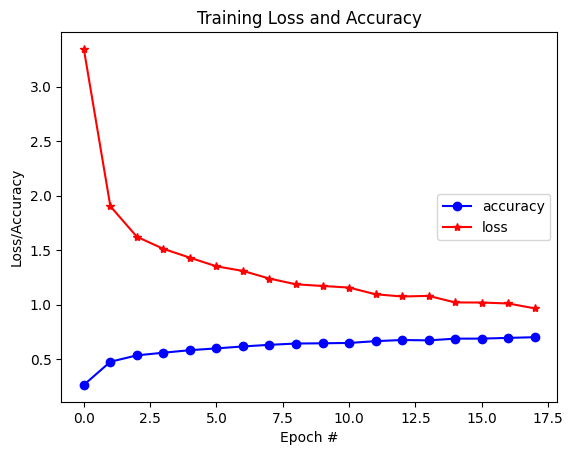

In [46]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [47]:
test_generator.reset()
eval_vgg = model_vgg.evaluate(test_generator)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 15s 5ms/step - loss: 1.1279 - accuracy: 0.6693
VGG Test loss:  1.1278877258300781
VGG Test Accuracy:  0.6693163514137268


In [48]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg_model.h5")

model updated


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#  Persist the models and evaluate on the test set

In [ ]:
# also run the first two cells to define file path and ramdom state

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input

from keras.models import load_model

In this step we load the saved models and evaluate them on the test set

In [ ]:
!ls

In [ ]:
# instantiate image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

image_resize = 224

test_dir = os.path.join(file_path,'test')

#check existence of the path
if os.path.isdir(test_dir):
    print("test set found!")
else:
    raise Exception("test set directory not found!")

In [ ]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
)

In [ ]:
print(test_generator.batch_size)

In [ ]:
class_names = {y: x for x, y in test_generator.class_indices.items()}
class_names

In [ ]:
# load the models

model_cnn = load_model('../saved_models/classifier_cnn_model.h5')

model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

In [ ]:
# Evaluate CNN on test_generator

test_generator.reset()
eval_cnn = model_cnn.evaluate(test_generator)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

In [ ]:
# Evaluate pre-trained model on test_generator

test_generator.reset()
eval_vgg = model_vgg.evaluate(test_generator)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

## Plot the Confusion Matrix

### We see that the VGG16 pre-trained model performs better than our defined CNN model.